<a href="https://colab.research.google.com/github/mohsenfayyaz/GlobEnc/blob/main/GlobEnc_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install requirements / Clone repository

In [2]:
! pip install datasets==1.18.3
! pip install transformers==4.18.0
! git clone https://github.com/mohsenfayyaz/GlobEnc

# Config (Change model and sentence here)

In [7]:
import torch
import numpy as np
from transformers import AutoTokenizer
from GlobEnc.src.modeling.modeling_bert import BertForSequenceClassification
from GlobEnc.src.modeling.modeling_electra import ElectraForSequenceClassification
from GlobEnc.src.attention_rollout import AttentionRollout

config = {
    # As of now, BERT and ELECTRA are supported. You can choose any checkpoing of these models.
    ### BERT-base
    "MODEL": "TehranNLP-org/bert-base-uncased-cls-sst2"
    # "MODEL": "TehranNLP-org/bert-base-uncased-cls-mnli"
    # "MODEL": "TehranNLP-org/bert-base-uncased-cls-hatexplain"
    ### BERT-large
    # "MODEL": "TehranNLP-org/bert-large-sst2"
    # "MODEL": "TehranNLP-org/bert-large-mnli"
    # "MODEL": "TehranNLP-org/bert-large-hateXplain"
    ### ELECTRA
    # "MODEL": "TehranNLP-org/electra-base-sst2"
    # "MODEL": "TehranNLP-org/electra-base-mnli"
    # "MODEL": "TehranNLP-org/electra-base-hateXplain"
}
SENTENCE = "A deep and meaningful film."

# Load corresponding model/tokenizer
As of now, BERT and ELECTRA are supported. You can choose any checkpoing of these models.

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config["MODEL"])
tokenized_sentence = tokenizer.encode_plus(SENTENCE, return_tensors="pt")
if "bert" in config["MODEL"]:
    model = BertForSequenceClassification.from_pretrained(config["MODEL"])
elif "electra" in config["MODEL"]:
    model = ElectraForSequenceClassification.from_pretrained(config["MODEL"])
else:
    raise Exception(f"Not implented model: {config['MODEL']}")

# Compute GlobEnc

In [10]:
# Extract single layer attentions
with torch.no_grad():
    logits, attentions, norms = model(**tokenized_sentence, output_attentions=True, output_norms=True, return_dict=False)
    num_layers = len(attentions)
    norm_nenc = torch.stack([norms[i][4] for i in range(num_layers)]).squeeze().cpu().numpy()
    print("Single layer N-Enc token attribution:", norm_nenc.shape)

    # Aggregate and compute GlobEnc
    globenc = AttentionRollout().compute_flows([norm_nenc], output_hidden_states=True)[0]
    globenc = np.array(globenc)
    print("Aggregated N-Enc token attribution (GlobEnc):", globenc.shape)

Single layer N-Enc token attribution: (12, 8, 8)


  0%|          | 0/1 [00:00<?, ?it/s]

Aggregated N-Enc token attribution (GlobEnc): (12, 8, 8)


# Visualization

logits: tensor([[-4.7060,  4.0975]])


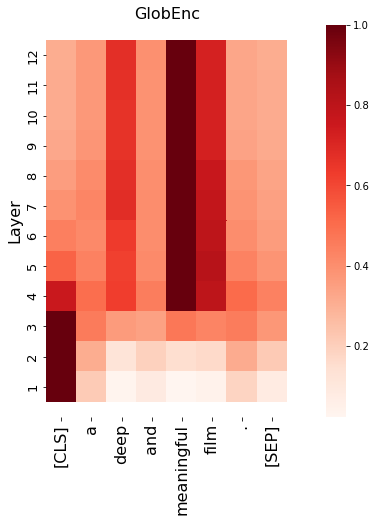

In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf

tokenized_text = tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"][0])
plt.figure(figsize=(14, 8))
norm_cls = globenc[:, 0, :]
norm_cls = np.flip(norm_cls, axis=0)
row_sums = norm_cls.max(axis=1)
norm_cls = norm_cls / row_sums[:, np.newaxis]
df = pd.DataFrame(norm_cls, columns=tokenized_text, index=range(len(norm_cls), 0, -1))
ax = sns.heatmap(df, cmap="Reds", square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("GlobEnc", fontsize=16)
plt.ylabel("Layer", fontsize=16)
plt.xticks(rotation = 90, fontsize=16)
plt.yticks(fontsize=13)
plt.gcf().subplots_adjust(bottom=0.2)
print("logits:", logits)